# Getting Started: Hybrid Renewable Energy Forecasting Hackathon

This notebook is a quick start guide intended to help participants get going
quickly.

## Requirements
Basic requirements:
- Python installation with standard libraries
- The `xarray` and `netCDF4` packages

In [2]:
import pandas as pd
import xarray as xr

## Weather data

Let's load the weather data. These data are historic weather forecasts on a spatial grid that spans southern Scotland. If you've never encountered this type of data before it can be a bit confusing, but the example below should get you started, and help is on hand from the hackathon organisers and volunteers.

The dimensions of the gridded data are:
- `time` The time the weather forecast was initialised (one per-day at midnight UTC)
- `step` The forecast lead-time (24 to 47 hours ahead)
- `longitude` and `latitude` (region spanning southern Scotland)

For convenience `valid_time` has been calculated and is a useful timestamp equal to `time` + `step`

The weather parameters are:
- `u10` and `v10` Zonal and meridional wind speed 10m above ground
- `t2m` and `d2m` Temperature and dew point 2m above ground
- `ssrd` Surface solar radiation downwards (accumulation from `time` to `step`)
- `lcc`, `mcc` and `hcc` Low, medium and high cloud cover
- `tp` Total precipitation
- `u100` and `v100` Zonal and meridional wind speed 100m above ground

For more detail see [ECMWF parameter database](https://codes.ecmwf.int/grib/param-db/).

These data were produce by the European Centre for Medium Range Weather Forecasting and are shared under a CC-BY license.

In [4]:
nwp = xr.load_dataset("data/hres_1day_south_scotland_202101_202306.nc")
nwp

<xarray.Dataset>
Dimensions:     (time: 910, step: 24, latitude: 20, longitude: 40)
Coordinates:
    number      int32 0
  * time        (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2023-06-29
  * step        (step) timedelta64[ns] 1 days 00:00:00 ... 1 days 23:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 56.5 56.4 56.3 56.2 ... 54.9 54.8 54.7 54.6
  * longitude   (longitude) float64 -5.9 -5.8 -5.7 -5.6 ... -2.3 -2.2 -2.1 -2.0
    valid_time  (time, step) datetime64[ns] 2021-01-02 ... 2023-06-30T23:00:00
Data variables:
    u10         (time, step, latitude, longitude) float32 1.792 1.656 ... 5.339
    v10         (time, step, latitude, longitude) float32 -0.4428 ... 1.849
    t2m         (time, step, latitude, longitude) float32 272.2 271.7 ... 287.0
    d2m         (time, step, latitude, longitude) float32 270.4 270.1 ... 285.7
    ssrd        (time, step, latitude, longitude) float32 1.984e+06 ... 2.972...
    lcc         (time, step, latitude, longitude) float32 0.293 ... 0.9994
    mcc         (time, step, latitude, longitude) float32 0.1332 ... 0.06424
    hcc         (time, step, latitude, longitude) float32 0.0 0.0 ... 0.0 0.0
    tp          (time, step, latitude, longitude) float32 0.0001106 ... 0.002985
    u100        (time, step, latitude, longitude) float32 1.654 2.525 ... 9.057
    v100        (time, step, latitude, longitude) float32 -3.708 ... 2.662
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-12-01T14:42 GRIB to CDM+CF via cfgrib-0.9.1...

We can calculate the wind speed from U and V wind components using Pythagoras...

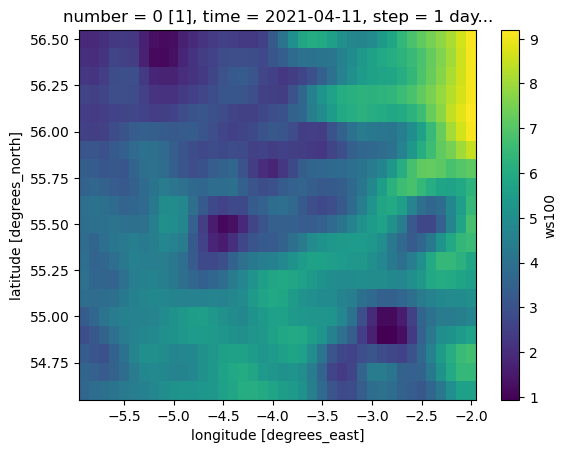

In [5]:
nwp["ws100"] = pow(pow(nwp.u100,2) + pow(nwp.v100,2), 0.5)
nwp["ws100"].isel(time=100,step=1).plot(x="longitude")

To quickly illustrate the relationship between wind speed and wind power, we'll calculate the average wind speed across the entire region.

<Axes: title={'center': 'Day-ahead wind speed forecasts'}, xlabel='valid_time'>

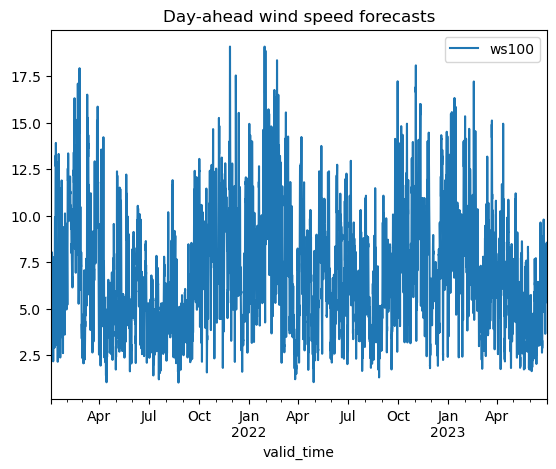

In [6]:
wind_speed_forecast = nwp["ws100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
wind_speed_forecast["valid_time"] = wind_speed_forecast["valid_time"].dt.tz_localize("UTC")
wind_speed_forecast.plot(x="valid_time",y="ws100",title="Day-ahead wind speed forecasts")

## Energy Data

Wind, solar and total power production are provided for 2021 to 2022. Your task is to forecast production for the first 6 months of 2023!

Note: Energy is metered in half-hourly time steps. You must predict every half-hour from 2023-01-01T00:00:00Z to 2023-06-30T23:30:00Z, however, the weather forecast data is hourly resolution.

Wind generation is the aggregate generation from 17 wind farms in central Scotland. Location and capacity data are provided in `Central Scotland Wind Farms.csv`. Curtailments originating from National Grid ESO have been corrected for. Solar generation is the (estimated) aggregate generation of all solar in Southern Scotland (Grid Supply Point Group P/PES Area 18).

[Contains BMRS data © Elexon Limited copyright and database right 2023](https://www.elexon.co.uk/data/balancing-mechanism-reporting-agent/copyright-licence-bmrs-data/) and data from Sheffield Solar PV Live [Terms](https://api.solar.sheffield.ac.uk/tandc).


In [8]:
energy_data = pd.read_csv("data/training_data.csv")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"],utc=True)
energy_data

,dtm,wind_generation_MW,solar_generation_MW,total_generation_MW
0,2021-01-01 00:00:00+00:00,544.598,0.0,544.598
1,2021-01-01 00:30:00+00:00,534.354,0.0,534.354
2,2021-01-01 01:00:00+00:00,482.512,0.0,482.512
3,2021-01-01 01:30:00+00:00,426.260,0.0,426.260
4,2021-01-01 02:00:00+00:00,346.434,0.0,346.434
...,...,...,...,...
35035,2022-12-31 21:30:00+00:00,825.848,0.0,825.848
35036,2022-12-31 22:00:00+00:00,767.696,0.0,767.696
35037,2022-12-31 22:30:00+00:00,769.064,0.0,769.064
35038,2022-12-31 23:00:00+00:00,809.050,0.0,809.050


<Axes: xlabel='dtm'>

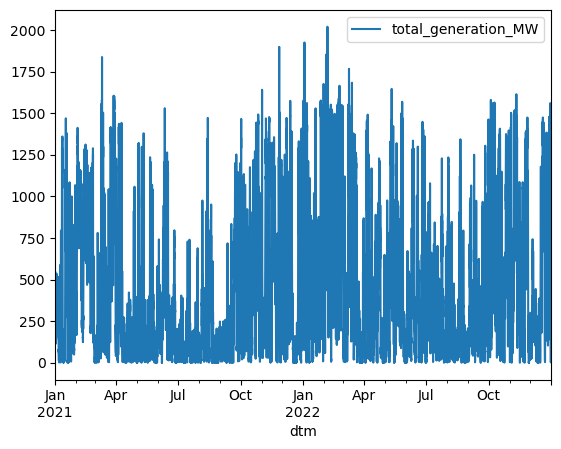

In [9]:
energy_data.plot(x="dtm",y="total_generation_MW")

If we merge and plot the (spatially) averaged wind speed with the wind generation we see... 

<Axes: xlabel='ws100', ylabel='wind_generation_MW'>

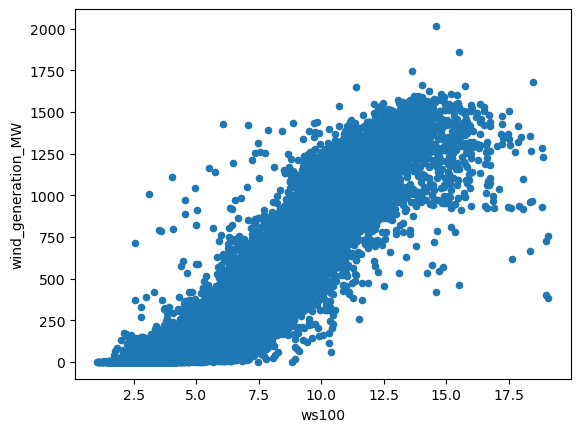

In [10]:
wind_speed_forecast.merge(
    energy_data,
    left_on="valid_time",
    right_on="dtm"
    ).plot.scatter(x="ws100",y="wind_generation_MW")